In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [5]:
cdl= pd.read_csv("Cdlstick.csv")

In [6]:
cdl.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume',
       'ignore'],
      dtype='object')

In [7]:
del cdl["quote_volume"]
del cdl["count"]
del cdl["taker_buy_volume"]
del cdl["taker_buy_quote_volume"]
del cdl["ignore"]

In [8]:
cdl.head()

,open_time,open,high,low,close,volume,close_time
0,1698796800000,34651.4,34676.5,34650.0,34669.9,376.040,1698796859999
1,1698796860000,34669.9,34684.0,34637.3,34637.4,431.177,1698796919999
2,1698796920000,34637.4,34653.4,34632.5,34651.4,175.894,1698796979999
3,1698796980000,34651.3,34651.4,34608.6,34621.1,476.587,1698797039999
4,1698797040000,34621.1,34622.6,34592.0,34615.4,546.312,1698797099999


In [9]:
cdl["open_time"]-= 1698796800000

In [10]:
cdl["open_time"]/= 1000
cdl["close_time"]-= 1698796800000
cdl["close_time"]/= 1000

<Axes: >

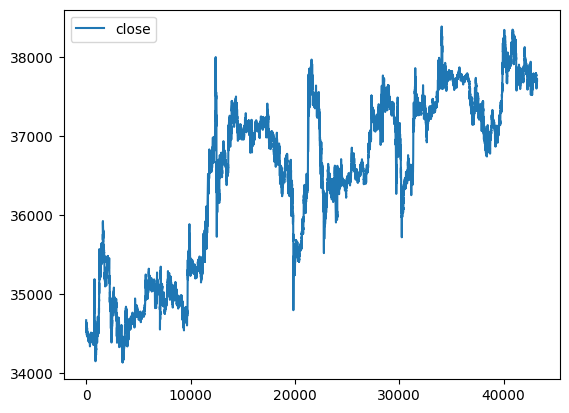

In [11]:
cdl.plot.line(y="close", use_index=True)

In [12]:
del cdl["close_time"]

In [13]:
cdl["next_min"] = cdl["close"].shift(-1)

In [14]:
cdl["Target"] = (cdl["next_min"] > cdl["close"]).astype(int)

In [15]:
cdl.head()

,open_time,open,high,low,close,volume,next_min,Target
0,0.0,34651.4,34676.5,34650.0,34669.9,376.040,34637.4,0
1,60.0,34669.9,34684.0,34637.3,34637.4,431.177,34651.4,1
2,120.0,34637.4,34653.4,34632.5,34651.4,175.894,34621.1,0
3,180.0,34651.3,34651.4,34608.6,34621.1,476.587,34615.4,0
4,240.0,34621.1,34622.6,34592.0,34615.4,546.312,34599.4,0


In [16]:
cdl.info

<bound method DataFrame.info of        open_time     open     high      low    close   volume  next_min  \
0            0.0  34651.4  34676.5  34650.0  34669.9  376.040   34637.4   
1           60.0  34669.9  34684.0  34637.3  34637.4  431.177   34651.4   
2          120.0  34637.4  34653.4  34632.5  34651.4  175.894   34621.1   
3          180.0  34651.3  34651.4  34608.6  34621.1  476.587   34615.4   
4          240.0  34621.1  34622.6  34592.0  34615.4  546.312   34599.4   
...          ...      ...      ...      ...      ...      ...       ...   
43195  2591700.0  37699.9  37701.9  37698.6  37698.6   29.083   37696.1   
43196  2591760.0  37698.6  37698.7  37696.0  37696.1    6.072   37691.9   
43197  2591820.0  37696.0  37696.1  37691.8  37691.9   24.287   37697.8   
43198  2591880.0  37691.9  37697.8  37691.8  37697.8   20.963   37716.8   
43199  2591940.0  37697.7  37716.9  37691.9  37716.8   54.218       NaN   

       Target  
0           0  
1           1  
2           0  
3  

In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = cdl.iloc[:-200]
test = cdl.iloc[-200:]

predictors = ["close", "volume", "open", "high", "low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [18]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5081967213114754

<Axes: >

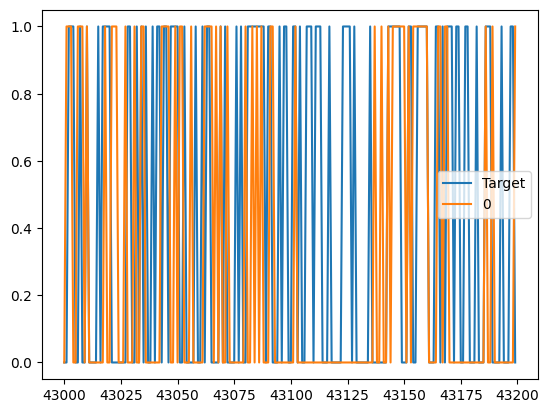

In [19]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [20]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [21]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [22]:
predictions = backtest(cdl, model, predictors)

In [23]:
predictions["Predictions"].value_counts()

Predictions
0    22616
1    18084
Name: count, dtype: int64

In [27]:
precision_score(predictions["Target"], predictions["Predictions"])

0.500055297500553

In [28]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = cdl.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    cdl[ratio_column] = cdl["close"] / rolling_averages["close"]
    
    trend_column = f"Trend_{horizon}"
    cdl[trend_column] = cdl.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [29]:
cdl = cdl.dropna(subset=cdl.columns[cdl.columns != "next_min"])

In [30]:
cdl.head()

,open_time,open,high,low,close,volume,next_min,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
1000,60000.0,34424.9,34432.4,34400.7,34407.2,489.000,34433.3,1,0.999741,0.0,0.998419,1.0,1.001465,33.0,0.997489,130.0,0.998225,479.0
1001,60060.0,34407.2,34433.3,34381.7,34433.3,599.468,34449.4,1,1.000379,1.0,0.999788,1.0,1.002147,34.0,0.998242,130.0,0.998989,480.0
1002,60120.0,34433.3,34456.1,34417.8,34449.4,198.897,34422.1,0,1.000234,2.0,1.000396,2.0,1.002521,35.0,0.998702,131.0,0.999461,480.0
1003,60180.0,34449.4,34452.0,34422.0,34422.1,129.673,34419.3,0,0.999604,1.0,0.999846,2.0,1.001647,34.0,0.997908,130.0,0.998675,480.0
1004,60240.0,34422.1,34430.0,34408.8,34419.3,137.179,34396.9,0,0.999959,0.0,0.999798,2.0,1.001481,34.0,0.997827,129.0,0.998600,480.0


In [31]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [32]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [33]:
predictions = backtest(cdl, model, new_predictors)

In [34]:
predictions["Predictions"].value_counts()

Predictions
0.0    38201
1.0     1499
Name: count, dtype: int64

In [35]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5330220146764509

In [36]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.506776
1    0.493224
Name: count, dtype: float64